In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

#imports

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from tensorflow.keras import layers
from tensorflow.keras import activations
from IPython import display
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import initializers
import datetime


AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_DEPTH = 3
BATCH_SIZE = 128
NUM_SAMPLES = 202599

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = (img - .5) / .5
    return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])

def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)

    else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

def data_generator():
    data_dir = 'data/img_align_celeba/*.jpg'
    list_ds = tf.data.Dataset.list_files(data_dir)
    processed_images = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    return prepare_for_training(processed_images)
data_gen = data_generator()

In [3]:
def make_generator_model():
    initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=.02)
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,), kernel_initializer=initializer))
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization(scale=False))

    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization(scale=False))

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization(scale=False))
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.ReLU())
    model.add(layers.BatchNormalization(scale=False))

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh', kernel_initializer=initializer))
    assert model.output_shape == (None, 64, 64, 3)
    model.add(layers.Activation('linear', dtype='float32'))
    

    return model

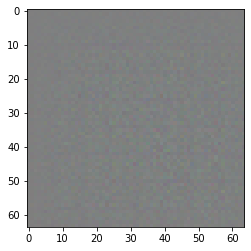

In [4]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow((generated_image[0] * .5 + .5))

In [5]:
def make_discriminator_model():
    initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=.02)
    model = tf.keras.Sequential()
    model.add(layers.GaussianNoise(0.2, input_shape = [64, 64, 3]))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(layers.LeakyReLU(alpha =  0.2))
    model.add(layers.BatchNormalization( scale=False))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(layers.LeakyReLU(alpha =  0.2))
    model.add(layers.BatchNormalization(scale=False))
    
    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
    model.add(layers.LeakyReLU(alpha =  0.2))
    model.add(layers.BatchNormalization(scale=False))



    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid', dtype='float32'))
    
    return model


In [6]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.501894]], shape=(1, 1), dtype=float32)


In [7]:
# TB Stuff
train_loss_G = tf.keras.metrics.Mean('train_loss_G', dtype=tf.float32)
train_loss_D = tf.keras.metrics.Mean('train_loss_G', dtype=tf.float32)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir_D = 'logs/' + current_time+ 'train/D_loss'
train_log_dir_G = 'logs/' + current_time+ 'train/G_loss'
train_log_dir_PIC = 'logs/' + current_time+ 'train/pic'

train_summary_writer_D = tf.summary.create_file_writer(train_log_dir_D)
train_summary_writer_G = tf.summary.create_file_writer(train_log_dir_G)
train_summary_writer_PIC = tf.summary.create_file_writer(train_log_dir_PIC)




In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) #from_logits true if not using (0,1)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = .0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = .0002, beta_1=0.5)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [9]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [10]:
EPOCHS = 400
noise_dim = 100
num_examples_to_generate = 4
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [11]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        
        disc_loss = discriminator_loss(real_output, fake_output)
        
#         TB Stuff
        train_loss_G(gen_loss)
        train_loss_D(disc_loss)

        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [12]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)
        
        results = generate_and_save_images(generator, epoch, seed)
        
        with train_summary_writer_D.as_default():
            tf.summary.scalar('loss', train_loss_D.result(), step=epoch)
        with train_summary_writer_G.as_default():
            tf.summary.scalar('loss', train_loss_G.result(), step=epoch)
        with train_summary_writer_PIC.as_default():
            name = "Epoch:" + str(epoch) + " Images"
            tf.summary.image(name, results, step=epoch, max_outputs = 4)
        
        train_loss_G.reset_states()
        train_loss_D.reset_states()

        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [13]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = predictions* 0.5 + 0.5 
    return predictions

In [14]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
train(data_gen, EPOCHS)

Time for epoch 1 is 194.35479474067688 sec
Time for epoch 2 is 187.5634527206421 sec
Time for epoch 3 is 190.93921566009521 sec
Time for epoch 4 is 195.0472538471222 sec
Time for epoch 5 is 189.13187789916992 sec
Time for epoch 6 is 192.32625699043274 sec
Time for epoch 7 is 188.6094048023224 sec
Time for epoch 8 is 190.18484354019165 sec
Time for epoch 9 is 191.83533453941345 sec
Time for epoch 10 is 194.46680736541748 sec
Time for epoch 11 is 186.4424343109131 sec
Time for epoch 12 is 190.0697319507599 sec
Time for epoch 13 is 306.39256167411804 sec
Time for epoch 14 is 394.10289239883423 sec
